In [31]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from IPython.display import clear_output

summary_files = glob.glob('../../../aldd_results/params_results/*/*/*/*/summary.csv')
p0 = np.unique([f.split('\\')[-3] for f in summary_files])

In [32]:
res_df_list = [[], [], []]
failed_jobs = []
all_jobs = []
for i, s_file in enumerate(summary_files):
    clear_output()
    print('{}/{}'.format(i, len(summary_files)))
    s_params = s_file.split('\\')
    config_file = s_file.replace('summary.csv', 'config.csv')
    dist_type = s_params[1]
    exploration_strategy = s_params[2]
    hs_name = s_params[3]
    batch_size = s_params[4]
    
    hs_info = [dist_type, exploration_strategy, hs_name, batch_size, config_file]
    hs_id = '{}_{}_{}_{}'.format(dist_type, exploration_strategy, hs_name, batch_size)
    
    all_jobs.append(hs_id)
    
    df = pd.read_csv(s_file, index_col=0)
    bsize_df = df[['exploitation_batch_size', 'exploration_batch_size']]
    exploit_df = df[[m for m in df.columns if 'exploitation_hits_at_' in m]].sum(axis=1).to_frame(name='exploitation_hits')
    explore_df = df[[m for m in df.columns if 'exploration_hits_at_' in m]].sum(axis=1).to_frame(name='exploration_hits')
    exploit_max_df = df[[m for m in df.columns if 'exploitation_max_hits_at_' in m]].sum(axis=1).to_frame(name='exploitation_max_hits')
    explore_max_df = df[[m for m in df.columns if 'exploration_max_hits_at_' in m]].sum(axis=1).to_frame(name='exploration_max_hits')
    
    sum_df = pd.concat([bsize_df, exploit_df, exploit_max_df, explore_df, explore_max_df], axis=1)
    sum_df['total_batch_size'] = sum_df['exploitation_batch_size'] + sum_df['exploration_batch_size']
    sum_df['total_hits'] = sum_df['exploitation_hits'] + sum_df['exploration_hits']
    sum_df['total_max_hits'] = sum_df['exploitation_max_hits'] + sum_df['exploration_max_hits']
    sum_df['total_max_hits'] = sum_df['total_max_hits'].apply((lambda x: min(x, int(batch_size.split('_')[-1]))))
    
    sum_df.iloc[-1,:] = sum_df.iloc[:-1,:].sum(axis=0)
    sum_df['iteration'] = list(range(10)) + [9999]
    sum_df['hyperparameter_id'] = hs_id
    sum_df.index = list(range(10)) + ['total']
    
    sum_df['config_file'] = config_file
    
    if batch_size == 'batch_size_96':
        res_df_list[0].append(sum_df)
    elif batch_size == 'batch_size_384':
        res_df_list[1].append(sum_df)
    else:
        res_df_list[2].append(sum_df)

all_0 = pd.concat(res_df_list[0])
all_1 = pd.concat(res_df_list[1])
all_2 = pd.concat(res_df_list[2])
all_0['hits_to_batch_size_ratio'] = all_0['total_hits'] / all_0['total_batch_size']
all_1['hits_to_batch_size_ratio'] = all_1['total_hits'] / all_1['total_batch_size']
all_2['hits_to_batch_size_ratio'] = all_2['total_hits'] / all_2['total_batch_size']
all_df = pd.concat([all_0, all_1, all_2])

1502/1503


In [33]:
print('Total hs: {}'.format(len(all_jobs)))
print('Failed hs: {}'.format(len(failed_jobs)))
print('Successfull hs: {}'.format(len(all_jobs) - len(failed_jobs)))

Total hs: 1503
Failed hs: 0
Successfull hs: 1503


---
# Plots

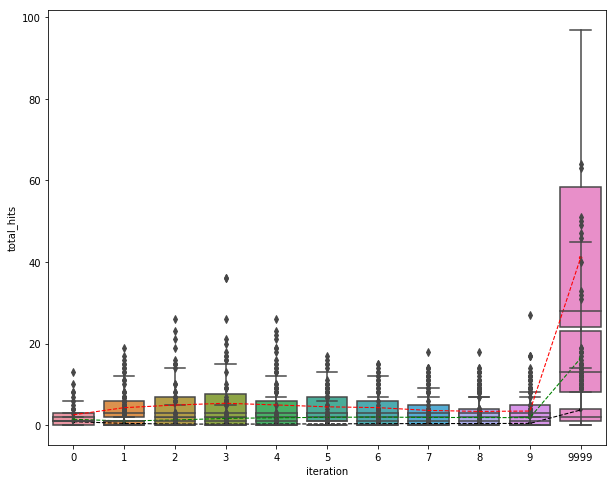

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.boxplot(x="iteration", y="total_hits", data=all_0)
sns.pointplot(x="iteration", y="total_hits", data=all_0, linestyles='--', scale=0.4, 
              color='k', errwidth=0, capsize=0)

sns.boxplot(x="iteration", y="total_hits", data=all_1)
sns.pointplot(x="iteration", y="total_hits", data=all_1, linestyles='--', scale=0.4, 
              color='g', errwidth=0, capsize=0)

sns.boxplot(x="iteration", y="total_hits", data=all_2)
sns.pointplot(x="iteration", y="total_hits", data=all_2, linestyles='--', scale=0.4, 
              color='r', errwidth=0, capsize=0)

plt.show()

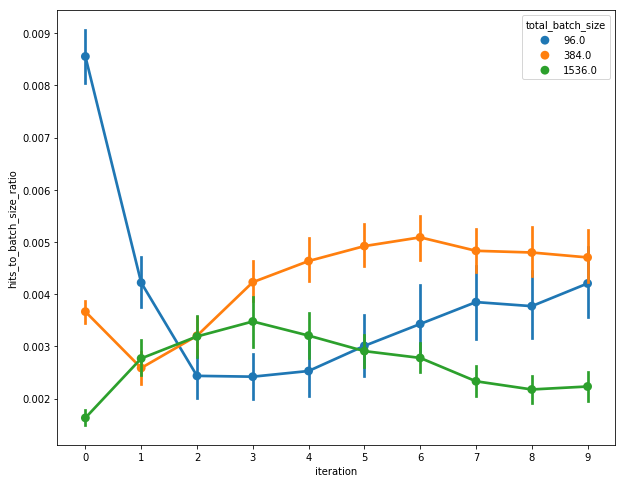

In [35]:
plt.figure(figsize=(10, 8))
#sns.boxplot(x="iteration", y="hits_to_batch_size_ratio", data=all_0)
sns.pointplot(x="iteration", y="hits_to_batch_size_ratio", hue="total_batch_size", data=all_df.drop('total'))
plt.show()

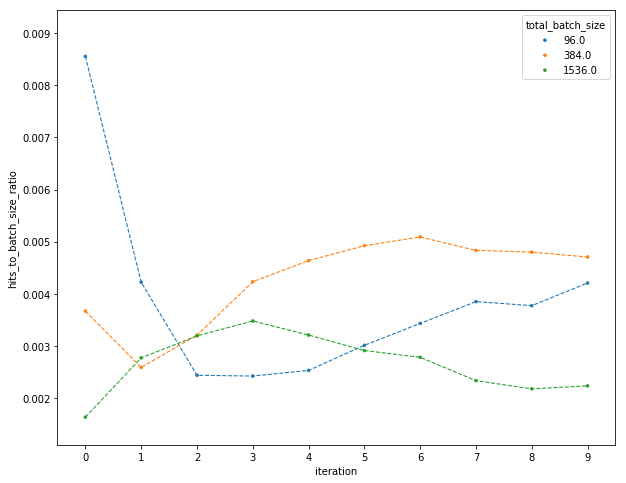

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.pointplot(x="iteration", y="hits_to_batch_size_ratio", hue="total_batch_size", 
              data=all_df.drop('total'), linestyles='--', scale=0.4, errwidth=0, capsize=0)
plt.show()

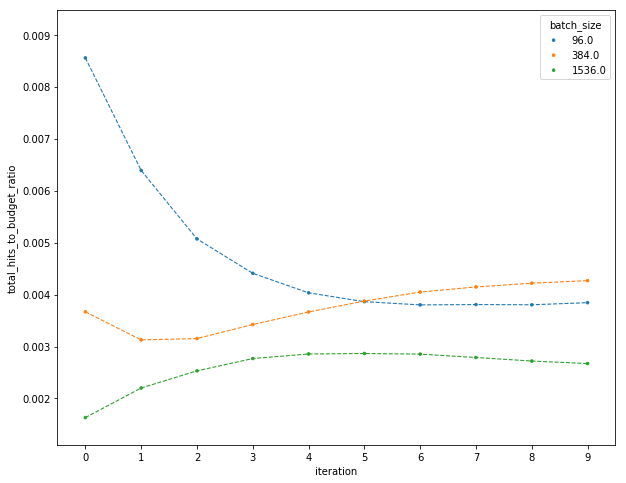

In [37]:
running_sum = all_df.drop('total').groupby('hyperparameter_id').cumsum(axis=0)
running_sum['total_hits_to_budget_ratio'] = running_sum['total_hits'] / running_sum['total_batch_size']
running_sum['batch_size'] = all_df.drop('total')['total_batch_size']
running_sum['iteration'] = all_df.drop('total')['iteration']

plt.figure(figsize=(10, 8))
sns.pointplot(x="iteration", y="total_hits_to_budget_ratio", hue="batch_size", 
              data=running_sum, 
              linestyles='--', scale=0.4, errwidth=0, capsize=0)
plt.show()

---
# In-Depth

In [152]:
top_hs_0 = all_0[all_0['iteration'] == 9999].sort_values('total_hits')
top_hs_0 = top_hs_0[top_hs_0['total_hits'] >= np.quantile(top_hs_0['total_hits'], 0.98)]
top_hs_0 = top_hs_0.reset_index(drop=True)

top_hs_1 = all_1[all_1['iteration'] == 9999].sort_values('total_hits')
top_hs_1 = top_hs_1[top_hs_1['total_hits'] >= np.quantile(top_hs_1['total_hits'], 0.95)]
top_hs_1 = top_hs_1.reset_index(drop=True)

top_hs_2 = all_2[all_2['iteration'] == 9999].sort_values('total_hits')
top_hs_2 = top_hs_2[top_hs_2['total_hits'] >= np.quantile(top_hs_2['total_hits'], 0.98)]
top_hs_2 = top_hs_2.reset_index(drop=True)

In [153]:
top_hs_0['total_hits']

0     15.0
1     15.0
2     15.0
3     15.0
4     15.0
5     15.0
6     15.0
7     16.0
8     17.0
9     18.0
10    18.0
11    18.0
12    18.0
13    19.0
14    19.0
15    31.0
16    32.0
17    33.0
18    40.0
Name: total_hits, dtype: float64

In [154]:
top_hs_1['total_hits']

0     38.0
1     38.0
2     38.0
3     38.0
4     38.0
5     38.0
6     39.0
7     40.0
8     40.0
9     40.0
10    40.0
11    40.0
12    41.0
13    41.0
14    41.0
15    42.0
16    42.0
17    43.0
18    43.0
19    43.0
20    43.0
21    43.0
22    44.0
23    44.0
24    45.0
25    45.0
26    46.0
27    47.0
28    49.0
29    50.0
30    51.0
31    63.0
32    64.0
Name: total_hits, dtype: float64

In [155]:
top_hs_2['total_hits']

0    92.0
1    93.0
2    94.0
3    97.0
Name: total_hits, dtype: float64

In [156]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

top_hs = top_hs_1

config_df = pd.concat([pd.read_csv(x) for x in top_hs['config_file']])
config_df = config_df.reset_index(drop=True)
req_cols = config_df.columns[2:-4]
mc_list = []
for c in req_cols:
    df = pd.concat([top_hs['total_hits'], config_df[c]], axis=1)
    mc = MultiComparison(df['total_hits'], df[c])
    mc_results = mc.tukeyhsd()
    
    if False in list(mc_results.reject):
        print(c)
        mc_list.append([c, mc_results])

exploitation_use_quantile_for_activity
exploitation_sample_actives_from_clusters
exploitation_activity_threshold
exploitation_use_quantile_for_weight
exploitation_weight_threshold
exploitation_alpha
exploitation_dissimilarity_lambda
use_intra_cluster_threshold_for_exploitation
use_proportional_cluster_budget_for_exploitation
exploration_strategy
exploration_use_quantile_for_weight
exploration_weight_threshold
exploration_beta
exploration_dissimilarity_lambda
use_intra_cluster_threshold_for_exploration
use_proportional_cluster_budget_for_exploration
select_dissimilar_instances_within_cluster
intra_cluster_dissimilarity_threshold


In [157]:
c=mc_list[0][0]
df = pd.concat([top_hs['total_hits'], config_df[c]], axis=1)
df[df[c] == 0.0]['total_hits'].mean(), df[df[c] == 0.25]['total_hits'].mean(), df[df[c] == 0.5]['total_hits'].mean(), df[df[c] == 0.75]['total_hits'].mean(), df[df[c] == 1.0]['total_hits'].mean()

(45.18181818181818, nan, nan, nan, 42.72727272727273)

exploitation_use_quantile_for_activity


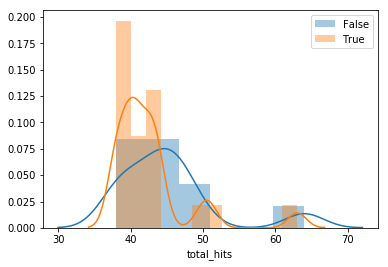

--------------------------------------------
exploitation_sample_actives_from_clusters


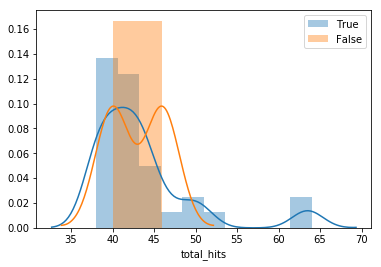

--------------------------------------------
exploitation_activity_threshold


C:\Users\Moeman\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Moeman\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


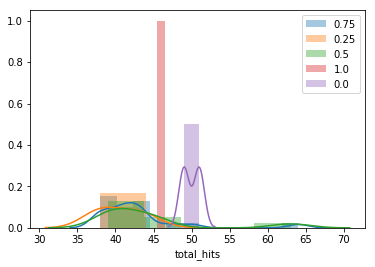

--------------------------------------------
exploitation_use_quantile_for_weight


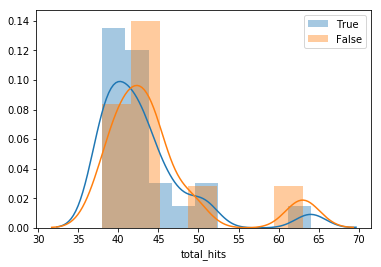

--------------------------------------------
exploitation_weight_threshold


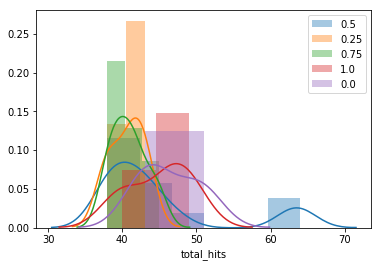

--------------------------------------------
exploitation_alpha


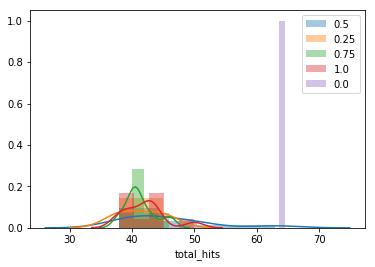

--------------------------------------------
exploitation_dissimilarity_lambda


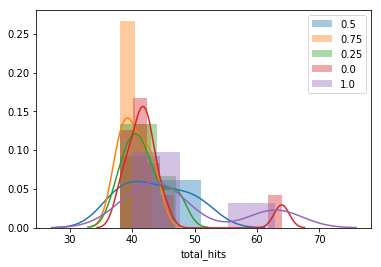

--------------------------------------------
use_intra_cluster_threshold_for_exploitation


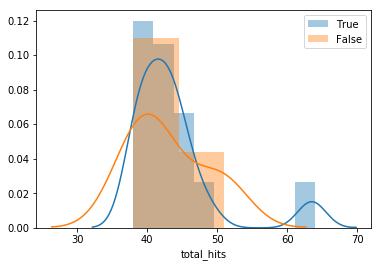

--------------------------------------------
use_proportional_cluster_budget_for_exploitation


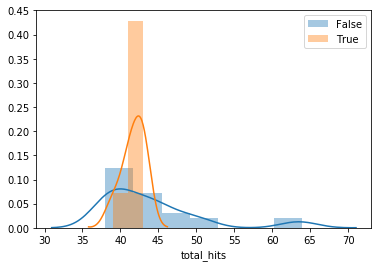

--------------------------------------------
exploration_strategy


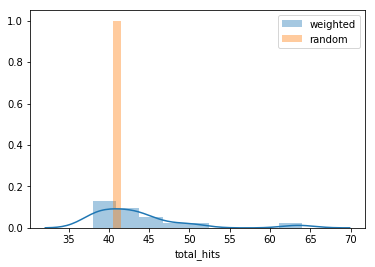

--------------------------------------------
exploration_use_quantile_for_weight


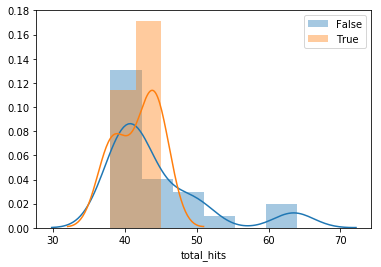

--------------------------------------------
exploration_weight_threshold


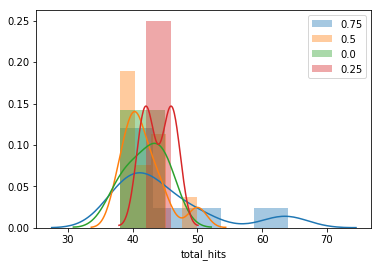

--------------------------------------------
exploration_beta


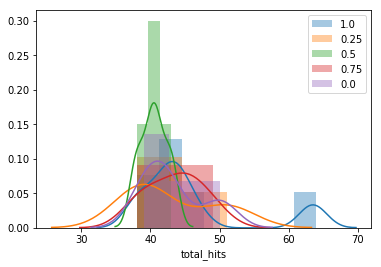

--------------------------------------------
exploration_dissimilarity_lambda


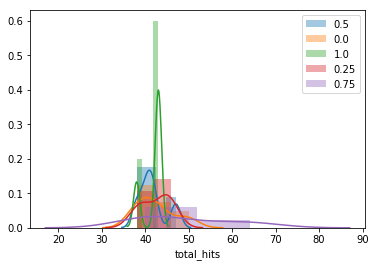

--------------------------------------------
use_intra_cluster_threshold_for_exploration


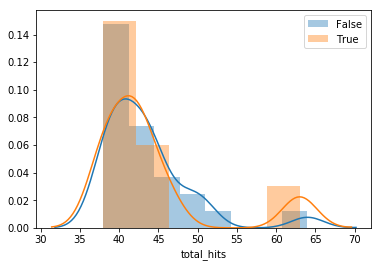

--------------------------------------------
use_proportional_cluster_budget_for_exploration


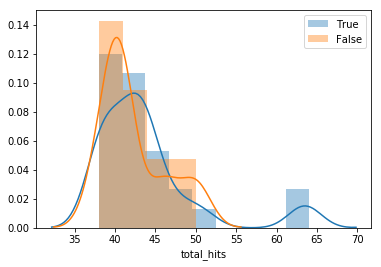

--------------------------------------------
select_dissimilar_instances_within_cluster


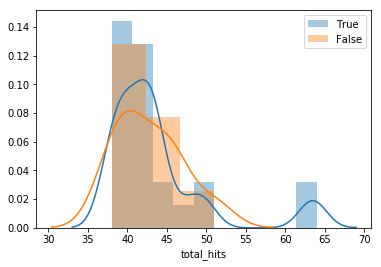

--------------------------------------------
intra_cluster_dissimilarity_threshold


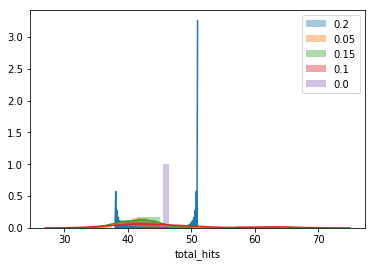

--------------------------------------------


In [158]:
for c in req_cols:
    df = pd.concat([top_hs['total_hits'], config_df[c]], axis=1)
    values = list(df[c].unique())
    print(c)
    for x in values:
        sns.distplot(df[df[c] == x]['total_hits'])
    plt.legend(values)
    plt.show()
    
    print('--------------------------------------------')

In [175]:
best_cf_list = []
best_hit_list = []
for top_hs in  [top_hs_0, top_hs_1, top_hs_2]:
    config_df = pd.concat([pd.read_csv(x) for x in top_hs['config_file']])
    config_df = config_df.reset_index(drop=True)
    best_hit_list.append(top_hs.iloc[-1:,:])
    best_cf_list.append(config_df.iloc[-1:,:])
best_cf = pd.concat(best_cf_list)
best_hit = pd.concat(best_hit_list)

In [176]:
best_cf

,class,batch_size,exploitation_use_quantile_for_activity,exploitation_sample_actives_from_clusters,exploitation_activity_threshold,exploitation_use_quantile_for_weight,exploitation_weight_threshold,exploitation_alpha,exploitation_dissimilarity_lambda,use_intra_cluster_threshold_for_exploitation,...,exploration_beta,exploration_dissimilarity_lambda,use_intra_cluster_threshold_for_exploration,use_proportional_cluster_budget_for_exploration,select_dissimilar_instances_within_cluster,intra_cluster_dissimilarity_threshold,feature_dist_func,use_consensus_distance,uncertainty_method,rnd_seed
18,ClusterBasedWCSelector,96,False,True,0.75,False,0.75,0.0,0.25,False,...,1.0,1.00,True,False,True,0.20,tanimoto_dissimilarity,True,least_confidence,182653426
32,ClusterBasedWCSelector,384,False,True,0.75,True,0.50,0.0,0.00,True,...,1.0,0.75,False,True,True,0.05,tanimoto_dissimilarity,True,least_confidence,1050474814
3,ClusterBasedWCSelector,1536,False,True,0.75,True,0.50,0.5,0.25,True,...,1.0,0.50,False,True,True,0.10,tanimoto_dissimilarity,True,least_confidence,84312657


In [179]:
best_hit[['total_batch_size', 'total_hits']]

,total_batch_size,total_hits
18,960.0,40.0
32,3840.0,64.0
3,15360.0,97.0
